In [4]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
# Read in all the words.
words = open('names.txt', 'r').read().splitlines()
print(f"Total amount of words: {len(words)}")

Total amount of words: 32033


In [6]:
# Build the vocabulary of characters and mappings to/from integers.
chars = sorted(list(set(''.join(words))))
stoi = {ch: ix + 1 for ix, ch in enumerate(chars)}
stoi['.'] = 0
itos = {ix: ch for ch, ix in stoi.items()}
vocab_size = len(itos)
print(f"Vocabulary size: {vocab_size}")

Vocabulary size: 27


In [7]:
def build_dataset(words: list[str], context_size: int = 3, logging: bool = False) -> tuple[torch.tensor]:
    """
    Given an list of string words, creates input and output targets.
    Args:
        words(list[int], shape=[n]): List of all words to sample examples from.
        context_size(int)          : How many characters are considered for prediction.
        logging(bool)              : Whether to print builded examples or not.
    Returns:
        X(torch.tensor, shape=[m, contex size]): Input tensor, where m is number of examples.
        Y(torch.tensor, shape=[m])             : Target tensor, where m is number of examples.
    """
    X, Y = [], []
    for word in words:
        context = [0] * context_size
        for ch in word + '.':
            X.append(context)
            Y.append(stoi[ch])
            context = context[1:] + [stoi[ch]]
    X, Y = torch.tensor(X), torch.tensor(Y)
    if logging:
        print(f'Input: {X.shape}, Output: {Y.shape}')
    return X, Y

In [8]:
import random
random.seed(13)
random.shuffle(words)
n1 = int(len(words) * 0.8)
n2 = int(len(words) * 0.9)


block_size = 3  # how many charecters do we take to predict the next one?
Xtr, Ytr = build_dataset(words[:n1], block_size, True)     # 80%
Xdev, Ydev = build_dataset(words[n1:n2], block_size, True) # 10%
Xte, Yte = build_dataset(words[n2:], block_size, True)     # 10%

Input: torch.Size([182597, 3]), Output: torch.Size([182597])
Input: torch.Size([22761, 3]), Output: torch.Size([22761])
Input: torch.Size([22788, 3]), Output: torch.Size([22788])


In [203]:
n_emb = 10  # the dimensionality of the character embedding vectors
n_hidden = 200  # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(13)
C = torch.randn(size=[vocab_size, n_emb],   generator=g)  #      gain          fan_in
W1 = torch.randn([n_emb * block_size, n_hidden], generator=g) * (5/3) / (n_emb * block_size)**0.5
#b1 = torch.randn([n_hidden],                     generator=g) * 0.01
W2 = torch.randn([n_hidden, vocab_size],         generator=g) * 0.01
b2 = torch.randn([vocab_size],                   generator=g) * 0.0

# BatchNorm parameters
bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1, W2, b2, bngain, bnbias ]
print("Total parametrs:", sum(p.nelement() for p in parameters))  # number of parameters in total
for p in parameters:
    p.requires_grad = True

Total parametrs: 12097


In [204]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    
    """Mini-batch construct"""
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix]  # batch X, Y
    
    """Forward pass"""
    emb = C[Xb]  # embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1) # concatenate vectors
    
    """Linear Layer"""
    hpreact = embcat @ W1  # + b1  # hidden layer pre-actvation
    
    """BatchNorm Layer"""
    # -----------------------------------------------------------
    bnmeani = hpreact.mean(0, keepdim=True)
    bnstdi = hpreact.std(0, keepdim=True)
    hpreact = bngain * (hpreact - bnmeani) / bnstdi  + bnbias
    with torch.no_grad():
        bnmean_running = bnmean_running * 0.999 + bnmeani * 0.001
        bnstd_running = bnstd_running * 0.999 + bnstdi * 0.001
    # -----------------------------------------------------------

    """Non-linearity"""
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2  # output layer
    loss = F.cross_entropy(logits, Yb)  # loss function
    
    """Backward pass"""
    for p in parameters:
        p.grad = None
    loss.backward()
    
    """Update"""
    lr = 0.1 if i < 100000 else 0.01  # learning step decay
    for p in parameters:
        p.data += -lr * p.grad
    
    """Track stats"""
    if i % 10000 == 0:
        print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
    lossi.append(loss.log10().item())

      0/ 200000: 3.3077
  10000/ 200000: 2.2307
  20000/ 200000: 2.0346
  30000/ 200000: 2.1815
  40000/ 200000: 2.1683
  50000/ 200000: 2.3454
  60000/ 200000: 2.1588
  70000/ 200000: 2.5568
  80000/ 200000: 1.8971
  90000/ 200000: 2.2496
 100000/ 200000: 2.0313
 110000/ 200000: 1.9457
 120000/ 200000: 2.1907
 130000/ 200000: 2.0456
 140000/ 200000: 2.0803
 150000/ 200000: 2.3353
 160000/ 200000: 2.0182
 170000/ 200000: 2.2302
 180000/ 200000: 2.1999
 190000/ 200000: 2.4662


<function matplotlib.pyplot.show(close=None, block=None)>

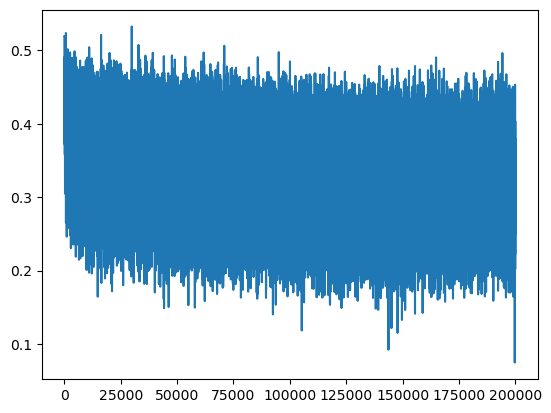

In [205]:
#  Look, hockey-stick loss fall is gone. No overconfidence - no wasteful training.
plt.plot([i for i in range(max_steps)], lossi)
plt.show

In [206]:
# Now here's a weird problem. Remember we've turned forward pass in a function of a examples in a given batch?
# After training there's this common technique, that you deploy your system somehow and use it.
# But how we evaluate a single examle, when the whole batch of them expected?

with torch.no_grad():
    # Pass the training set through
    emb = C[Xtr]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1# + b1
    # Measure mean/std over the entire training set (get constant values for single example evaluation)
    bnmean = hpreact.mean(0, keepdim=True)
    bnstd = hpreact.std(0, keepdim=True)

# Well, that thing works just fine and we could leave it as that, but in reality everyone's lazy and reject second stage
# That being taken as a fact, we'll initialize running mean and std as zeros and ones accordingly
# All that's left is to soft-update those values    

In [207]:
@torch.no_grad()  # this decorator disables gradient tracking
def split_loss(split: str) -> None:
    """
    Given a split name, evaluates it and prints the result.
    Args:
        split(str): name of the dataset split you'd like to evaluate.
    """
    x, y = {
        'train': (Xtr, Ytr),
        'dev': (Xdev, Ydev),
        'test': (Xte, Yte)
    }[split]

    emb = C[x] 
    embcat = emb.view(emb.shape[0], -1) 
    hpreact = embcat @ W1# + b1
    hpreact = bngain * (hpreact - bnmean_running) / bnstd_running  + bnbias  # batch-norm
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(f'{split}: {loss.item()}')

In [208]:
split_loss("train")
split_loss("test")

train: 2.066448450088501
test: 2.1092488765716553


In [209]:
# Sample from the model.
g = torch.Generator().manual_seed(13 + 10)
for _ in range (20):
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
        # forward pass the neural net
        emb = C[torch.tensor([context])] # (1, block_size, n_embd)
        hpreact = emb.view(1, -1) @ W1
        hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
        h = torch.tanh(hpreact)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        # sample from the distribution
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        # shift the context window and track the samples
        context = context[1:] + [ix]
        out.append(ix)
        # if we sample the special '' token, break
        if ix == 0:
            break
    print("".join(itos[i] for i in out)) # decode and print the generated word

jamerremjlaya.
mivia.
mabelle.
hazanah.
hawan.
ridy.
elivyous.
meka.
jonashn.
laure.
feralyn.
shawsitan.
zyre.
fladella.
jodumanoila.
zelin.
lae.
hair.
egan.
sevadancetilla.


In [90]:
class Linear():
    def __init__(self, fan_in: int, fan_out: int, bias: bool = True) -> None:
        self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x: torch.tensor) -> torch.tensor:
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias      
        return self.out

    def parameters(self) -> list:
        return [self.weight] + ([self.bias] if self.bias is not None else [])
    

class BatchNorm1d():
    def __init__(self, dim: int, eps: float = 1e-5, momentum: float = 0.1) -> None:
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # parameters (trained with backprop)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # buffers (trained wdith a running 'momentum update')
        self.running_mean = torch.zeroes(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x: torch.tensor) -> torch.tensor:
        if self.training:
            xmean = x.mean(0, keepdim=True)
            xvar = x.var(0, keepdim=True)
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
        self.out = self.gamma * xhat + self.beta
        # update the buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = self.running_mean * (1.0 - self.momentum) + xmean * self.momentum
                self.running_var = self.running_var * (1.0 - self.momentum) + xvar * self.momentum
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]


class Tanh():
    def __call__(self, x: torch.tensor) -> torch.tensor:
        self.out = torch.tanh(x)
        return self.out
    
    def parameters(self):
        return []
    

n_emb = 10  # the dimensionality of the character embedding vectors
n_hidden = 100  # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647)
C = torch.randn([vocab_size, n_emb], generator=g)

layers = [
    Linear(n_emb * block_size, n_hidden), Tanh(),
    Linear(          n_hidden, n_hidden), Tanh(),
    Linear(          n_hidden, n_hidden), Tanh(),
    Linear(          n_hidden, n_hidden), Tanh(),
    Linear(          n_hidden, n_hidden), Tanh(),
    Linear(n_hidden, vocab_size)
]

with torch.no_grad():
    # last layer: make less confident
    layers[-1].weight *= 0.1
    # all other layers: apply gain
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

46497


In [91]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    
    """Mini-batch construct"""
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix]  # batch X, Y
    
    """Forward pass"""
    emb = C[Xb]  # embed the characters into vectors
    x = emb.view(emb.shape[0], -1) # concatenate vectors
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb)  # loss function
    
    """Backward pass"""
    for layer in layers:
        layer.out.retain_grad()  # AFTER_DEBUG: would take out retain_grad
    
    for p in parameters:
        p.grad = None
    loss.backward()
    
    """Update"""
    lr = 0.1 if i < 100000 else 0.01  # learning step decay
    for p in parameters:
        p.data += -lr * p.grad
    
    """Track stats"""
    if i % 10000 == 0:
        print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
    lossi.append(loss.log10().item())

    break  # AFTER_DEBUG: would take out obviously to run full optimization

      0/ 200000: 3.3381


layer 1  Tanh | mean -0.05 | std 0.92 | saturated: 68.44%
layer 3  Tanh | mean -0.02 | std 0.91 | saturated: 64.81%
layer 5  Tanh | mean 0.02 | std 0.92 | saturated: 65.88%
layer 7  Tanh | mean -0.03 | std 0.92 | saturated: 66.22%
layer 9  Tanh | mean -0.02 | std 0.91 | saturated: 64.62%


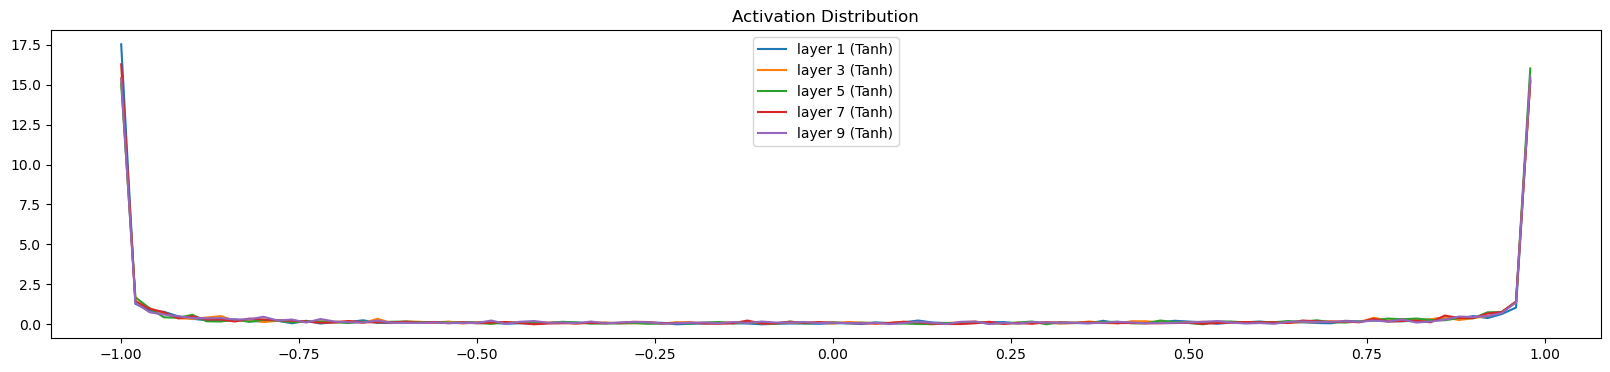

In [94]:
# visualize histograms
plt.figure(figsize=(20, 4))
legends = []
for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out
        logs = [i, layer.__class__.__name__, t.mean().item(), t.std().item(), ((t.abs() > 0.97).float().mean()*100).item()]
        print(f'layer {logs[0]}  {logs[1]} | mean {logs[2]:.2f} | std {logs[3]:.2f} | saturated: {logs[4]:.2f}%')
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {logs[0]} ({logs[1]})')
plt.legend(legends)
plt.title('Activation Distribution');

layer 1  Tanh | mean -0.000035 | std 0.002291
layer 3  Tanh | mean -0.000032 | std 0.001334
layer 5  Tanh | mean 0.000020 | std 0.000816
layer 7  Tanh | mean -0.000010 | std 0.000505
layer 9  Tanh | mean -0.000002 | std 0.000305


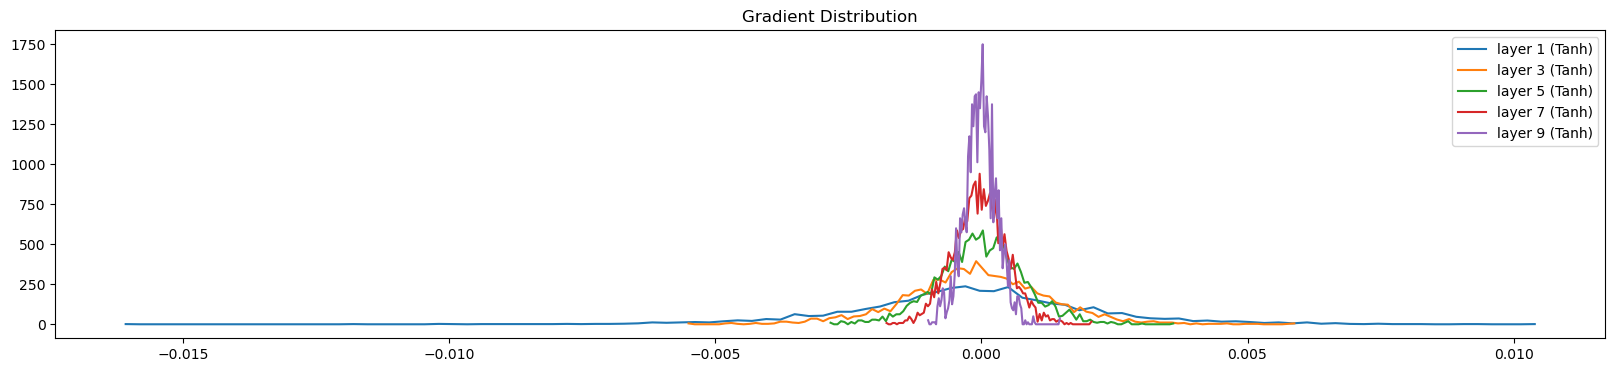

In [95]:
# visualize histograms
plt.figure(figsize=(20, 4))
legends = []
for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out.grad
        logs = [i, layer.__class__.__name__, t.mean().item(), t.std().item()]
        print(f'layer {logs[0]}  {logs[1]} | mean {logs[2]:.6f} | std {logs[3]:.6f}')
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {logs[0]} ({logs[1]})')
plt.legend(legends)
plt.title('Gradient Distribution');